**Câu hỏi:** Ở giá tiền nào thì nhà đầu tư sẽ có được biên lợi nhuận tốt nhất?

**Ý nghĩa:** Tối ưu hóa nguồn vốn đầu tư, nhà đầu tư có thể dùng phần vốn thừa ra để đầu tư các hạng mục khác, mang lại lợi nhuận cao hơn.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

c:\Users\ndh01\anaconda3\Lib\site-packages\torch\_subclasses\functional_tensor.py:295: UserWarning: Failed to initialize NumPy: DLL load failed while importing _multiarray_umath: The specified module could not be found. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [2]:
raw_df = pd.read_csv("../data/cleaned_movies_no_outliers.csv")

In [3]:
raw_df["profit_margin"] = (raw_df["worldwide"] - raw_df["budget"]) / raw_df["budget"]
raw_df['year'] = 2024 - raw_df['years_from_release']
data = raw_df.drop(columns=['popularity', 'title', 'vote_average', 'vote_count', 'imdb_id', 'domestic', 'international', 'worldwide', 'years_from_release'])

C:\Users\ndh01\AppData\Local\Temp\ipykernel_5184\3132630342.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


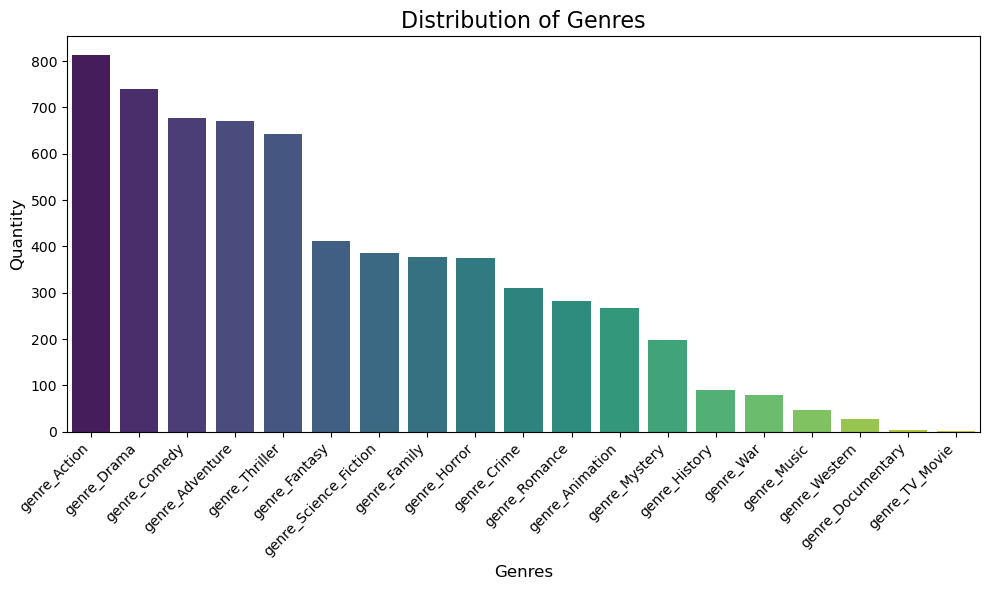

In [4]:
genre_columns = [col for col in data.columns if col.startswith('genre_')]

genre_counts = data[genre_columns].sum().sort_values(ascending=False)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Distribution of Genres', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
# Hợp nhất các thể loại có ít phim để giảm độ phức tạp của mô hình
merge_col = []
for col in data:
    if 'genre_' in col:
        if data[col].sum() < 300:
            merge_col.append(col)

data['other_genre'] = data[merge_col].sum(axis=1)
data.drop(columns=merge_col, inplace=True)

In [6]:

from sklearn.preprocessing import StandardScaler

# Chuẩn hóa budget
scaler = StandardScaler()
data['budget'] = scaler.fit_transform(data[['budget']])

data

,budget,runtime,genre_Action,genre_Adventure,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Science_Fiction,genre_Thriller,profit_margin,year,other_genre
0,2.436462,128,True,False,True,False,False,False,False,False,True,False,5.689504,2024,0
1,-0.642418,141,False,False,False,False,True,False,False,True,True,False,1.940764,2024,0
2,0.327640,104,False,True,False,False,False,True,False,False,True,False,0.718349,2024,1
3,3.279991,124,True,False,True,False,False,False,True,False,False,False,-0.660519,2024,0
4,0.411993,119,False,False,False,False,False,False,False,True,True,False,3.385763,2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,-0.262830,119,False,False,False,True,True,False,False,False,False,True,1.168809,2011,0
2259,-0.684594,98,False,False,False,False,False,False,True,True,False,False,-0.764379,2008,1
2260,-0.617112,161,True,False,False,True,True,False,False,False,False,False,-0.873809,2024,0
2261,-0.870171,91,False,False,True,False,False,False,False,True,False,False,2.560328,1985,0


In [7]:
data['profit_margin'].describe()

count      2263.000000
mean        115.438473
std        5169.017928
min          -0.999980
25%           0.608176
50%           2.063880
75%           4.528124
max      245865.000000
Name: profit_margin, dtype: float64

Tứ phân vị thứ 3 là khoảng 4.5 mà max lại là 245865. Cùng với độ lệch chuẩn cao bất thường cho thấy dữ liệu đang bị lệch phải nhiều. Chúng em sẽ bỏ các phần ngoại lai cụ thể là những giá trị lớn hơn Q3 + 1.5 * IQR

In [8]:
data = data[data['profit_margin'] < 10.5]

In [9]:
y = data['profit_margin'].values
X = data.drop(columns=['profit_margin']).values

Sau đó em sẽ chia tập train, validation, test với tỉ lệ là 0.8, 0.1, 0.1

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train data shape: " + str(X_train.shape))
print("Validate data shape: " + str(X_val.shape))
print("Test data shape: " + str(X_test.shape))

Train data shape: (1644, 14)
Validate data shape: (206, 14)
Test data shape: (206, 14)


Em sẽ cho chạy lần lượt qua các tổ hợp giá trị của siêu tham số để dò mô hình tốt nhất với tập train và tập validation

In [11]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10]
}

best_params = None
best_mse = float('inf')  

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_split in param_grid["min_samples_split"]:
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            
            mse = mean_squared_error(y_val, y_pred)
            
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "min_samples_split": min_samples_split
                }

print("Best Parameters:", best_params)
print("Best Validation MSE:", best_mse)

Best Parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}
Best Validation MSE: 5.772477007209607


Sau đó, em sẽ xây dựng mô hình với siêu tham số tốt nhất tìm được và train lại, sau đó kiểm tra trên tập test

In [12]:
final_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R2 Score:", test_r2)

Test MSE: 5.507034613006681
Test MAE: 1.8145263955139397
Test R2 Score: 0.0569349366904679


R2 trên tập test khá thấp, cho thấy mô hình ít tổng quát được mối quan hệ giữa input và output. Điều này có thể là do dữ liệu đang hơi ít(chỉ khoảng 1600 mẫu) cho việc học. Em sẽ thử biểu diễn các dữ liệu để xem thử mối quan hệ giữa chúng.

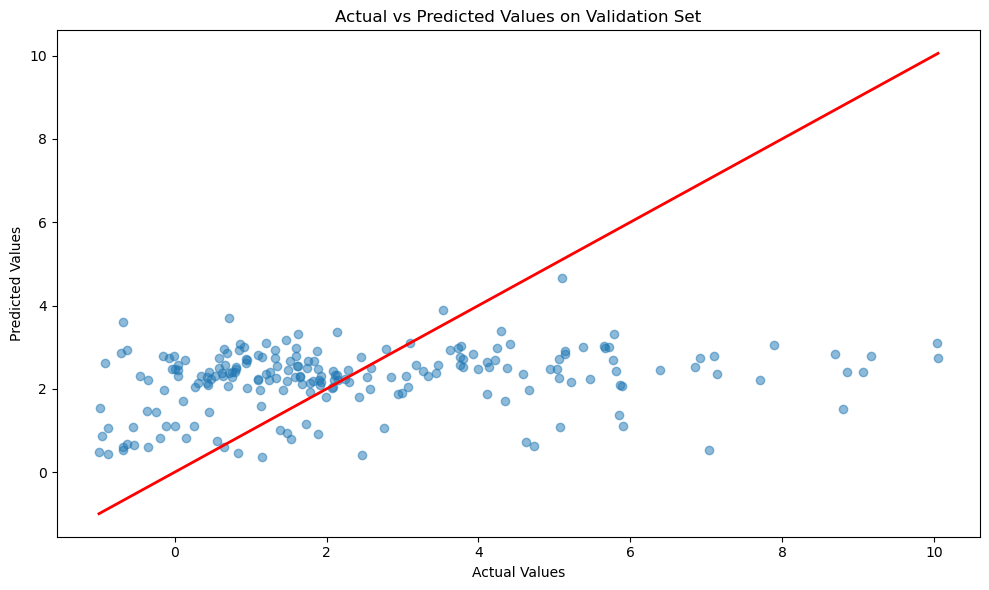

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.tight_layout()
plt.show()

Em sẽ thử 1 mô hình phức tạp hơn như neuron network

In [14]:
# Chuyển đổi dữ liệu thành tensor của PyTorch
train_data = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
val_data = torch.tensor(X_val, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.float32)

batch_size = 103

# Gắn các liên kết dữ liệu, nhãn bằng TensorDataset. Sau đó chia thành các batch để đưa vào các cấu trúc thùng chứa bằng DataLoader
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class ProfitMarginRegression(nn.Module):
    def __init__(self):
        super(ProfitMarginRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(14, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.model(x)
    
model = ProfitMarginRegression()

# Định nghĩa loss function (Mean Squared Error cho hồi quy)
criterion = nn.MSELoss()

# Optimizer (Adam thường được sử dụng)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
best_params = None
best_loss = float('inf')
for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Xóa gradient cũ để tránh việc gradient được tính tổng qua các batch, làm kết quả sai lệch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        avg_loss = running_loss / len(train_loader)

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_param = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= 5:
                print("Early stopping triggered!")
                break

c:\Users\ndh01\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ndh01\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Early stopping triggered!


In [17]:
if best_param is not None:
    model.load_state_dict(best_param)
    print("Restored the model with the best parameters.")

model.eval()

# Dự đoán trên tập test
val_pred = []
val_labels = []

with torch.no_grad():  # Không tính toán gradient trong giai đoạn dự đoán
    for val_inputs, test_targets in val_loader:
        # Dự đoán
        val_outputs = model(val_inputs)
        
        # Lưu lại kết quả dự đoán và labels thực tế
        val_pred.append(val_outputs.tolist())
        val_labels.append(test_targets.tolist())


val_pred = np.array(val_pred)
val_labels = np.array(val_labels)

val_pred = val_pred.reshape(-1, 1)
val_labels = val_labels.reshape(-1,1)

mse = mean_squared_error(val_labels, val_pred)
print(f"Test MSE: {mse}")

r2 = r2_score(val_labels, val_pred)
print(f"Test R2: {r2}")

Restored the model with the best parameters.
Test MSE: 6.331415835060106
Test R2: -0.007665504318430383


Giá trị test trên `Neuron Network` còn tệ hơn trên `RandomForest`. Điều này có thể là do mô hình em xây chưa tốt, nhưng em nghĩ với sai các giá trị tệ như này thì cũng không cải thiện được nhiêu.

Giả thuyết ban đầu chúng em đưa ra là mô hình đang quá đơn giản và dữ liệu cũng không đủ nhiều để huấn luyện mô hình. Vì vậy đây cũng có thể là hướng phát triển trong tương lai của nhóm khi đây là 1 câu hỏi sẽ nhận được nhiều sự quan tâm của các nhà đầu tư,...

Tiếp theo, từ mô hình tốt nhất mà chúng em xây dựng được là mô hình `final_model`, chúng em sẽ xây dựng hàm `optimize_budget` bằng các cho chạy thử các tiền đầu tư trong khoảng cho trước và xem thử ở giá tiền nào thì biên lợi nhuận sẽ cao nhất

In [18]:
def optimize_budget(budget_max, budget_min, infor_movie):
    result = 0
    max_margin = float('-inf')
    for budget in range(budget_min, budget_max + 1, int((budget_max - budget_min) / 20)):
        input = [budget] + infor_movie.copy()
        predicted_margin = final_model.predict(np.array(input).reshape(1,-1))
        if predicted_margin > max_margin:
            result = budget
    return result

r = 5270000
infor_movie1 = [90,True,True,False,False,False,False,False,False,True,True,2024,0]
infor_movie2 = [90,1,1,0,0,0,0,0,0,1,1,2024,0]
print(optimize_budget(100000, 10000000, infor_movie1))
print(optimize_budget(100000, 10000000, infor_movie2))

595000
595000
